# Single-image interactive debug (Qwen2.5-VL)

This notebook mirrors `single_image_hf.sbatch` and `single_image_lmdeploy.sbatch` in an interactive, debuggable way.

- Switch between **Transformers (HF)** and **lmdeploy**.
- Quickly change **task**, **prompt**, **image**, and **model weights**.
- Displays the input image, prints prompt/wrapped prompt, and shows the response + basic stats.


In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Literal

import os
import sys
import textwrap

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt

try:
    import torch
except Exception as e:
    raise RuntimeError("This notebook requires torch installed in the current kernel.") from e


REPO_ROOT = Path.cwd()
print("Python:", sys.version)
print("CWD:", REPO_ROOT)
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
print("CUDA devices:", torch.cuda.device_count())
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
        props = torch.cuda.get_device_properties(i)
        print(f"  cuda:{i} -> {props.name}, {props.total_memory/1024**3:.1f} GiB")


/gpfs/helios/home/kelemnegasi/binding-open-vlm/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


Python: 3.12.3 (main, Feb 18 2025, 16:17:24) [GCC 9.2.0]
CWD: /gpfs/helios/home/kelemnegasi/binding-open-vlm
Torch: 2.8.0+cu128
CUDA available: True
CUDA devices: 1
  cuda:0 -> NVIDIA A100-SXM4-80GB, 79.3 GiB


In [3]:
# --- Config (edit this cell) ---

Backend = Literal["hf", "lmdeploy"]
LmdeployEngine = Literal["auto", "turbomind", "pytorch"]
LmdeployPromptStyle = Literal["plain", "im_start_image", "qwen2_chat", "qwen2vl_vision_tokens"]

@dataclass
class RunConfig:
    backend: Backend = "lmdeploy"  # "hf" or "lmdeploy"
    weights: str = "model-weights/Qwen2.5-VL-32B-Instruct-AWQ"
    image_path: str = "data/vlm/3D/disjunctive_search/images/disjunctive_search_uniform_n35_003508.png"
    prompt_path: Optional[str] = "prompts/disjunctive_search_3D.txt"
    prompt_text: Optional[str] = None  # overrides prompt_path if set
    max_new_tokens: int = 512

    # HF (Transformers) settings
    hf_dtype: str = "float16"  # "auto" | "float16" | "bfloat16" | "float32"
    hf_device_map: str = "auto"  # "auto" or "cpu" (or a dict)

    # lmdeploy settings
    lmdeploy_engine: LmdeployEngine = "auto"  # auto | turbomind | pytorch
    lmdeploy_max_context_token_num: Optional[int] = None  # legacy alias; prefer lmdeploy_tm_session_len
    lmdeploy_tm_dtype: str = "auto"  # Turbomind dtype override (auto/float16/bfloat16/float32)
    lmdeploy_tm_session_len: Optional[int] = None
    lmdeploy_tm_max_batch_size: Optional[int] = None
    lmdeploy_tm_max_prefill_token_num: Optional[int] = None
    lmdeploy_tm_num_tokens_per_iter: Optional[int] = None
    lmdeploy_tm_max_prefill_iters: Optional[int] = None
    lmdeploy_tm_enable_prefix_caching: bool = False
    lmdeploy_tm_cache_max_entry_count: float = 0.8
    lmdeploy_tm_quant_policy: int = 0
    lmdeploy_tm_devices: Optional[list[int]] = None
    lmdeploy_prompt_style: LmdeployPromptStyle = "plain"  # plain | im_start_image | qwen2_chat | qwen2vl_vision_tokens
    lmdeploy_temperature: float = 0.0
    lmdeploy_top_p: float = 1.0
    lmdeploy_repetition_penalty: float = 1.05


cfg = RunConfig()
print(cfg)


RunConfig(backend='lmdeploy', weights='model-weights/Qwen2.5-VL-32B-Instruct-AWQ', image_path='data/vlm/3D/disjunctive_search/images/disjunctive_search_uniform_n35_003508.png', prompt_path='prompts/disjunctive_search_3D.txt', prompt_text=None, max_new_tokens=512, hf_dtype='float16', hf_device_map='auto', lmdeploy_engine='auto', lmdeploy_max_context_token_num=None, lmdeploy_tm_dtype='auto', lmdeploy_tm_session_len=None, lmdeploy_tm_max_batch_size=None, lmdeploy_tm_max_prefill_token_num=None, lmdeploy_tm_num_tokens_per_iter=None, lmdeploy_tm_max_prefill_iters=None, lmdeploy_tm_enable_prefix_caching=False, lmdeploy_tm_cache_max_entry_count=0.8, lmdeploy_tm_quant_policy=0, lmdeploy_tm_devices=None, lmdeploy_prompt_style='plain', lmdeploy_temperature=0.0, lmdeploy_top_p=1.0, lmdeploy_repetition_penalty=1.05)


In [4]:
# Optional: quick task presets

TASK_PRESETS = {
    "disjunctive_search_3D": {
        "image_path": "data/vlm/3D/disjunctive_search/images/disjunctive_search_uniform_n35_003508.png",
        "prompt_path": "prompts/disjunctive_search_3D.txt",
    },
    "counting_3D": {
        "image_path": "data/vlm/3D/counting_high_diversity/images/counting_high_diversity_n10_001000.png",
        "prompt_path": "prompts/counting_3D.txt",
    },
}

# Change this to switch task quickly:
task_name = "disjunctive_search_3D"  # or "counting_3D"

if task_name in TASK_PRESETS:
    cfg.image_path = TASK_PRESETS[task_name]["image_path"]
    cfg.prompt_path = TASK_PRESETS[task_name]["prompt_path"]
    cfg.prompt_text = None

print("Using task:", task_name)
print("image_path:", cfg.image_path)
print("prompt_path:", cfg.prompt_path)


Using task: disjunctive_search_3D
image_path: data/vlm/3D/disjunctive_search/images/disjunctive_search_uniform_n35_003508.png
prompt_path: prompts/disjunctive_search_3D.txt


Prompt chars: 376
Prompt preview:
 You are presented with an image containing several objects. Your task is to determine if there are any red objects in the image. Follow these steps carefully: 1. Describe each object in the image, noting their color. 2. Conclude your ...
Image size: (640, 480) mode: RGB


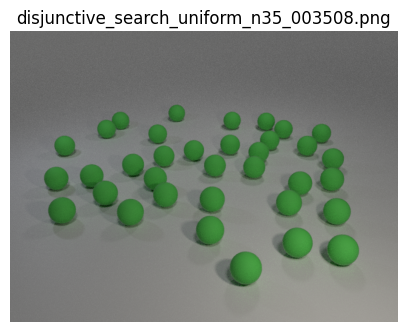

In [5]:
def load_prompt(cfg: RunConfig) -> str:
    if cfg.prompt_text is not None:
        return cfg.prompt_text
    if not cfg.prompt_path:
        raise ValueError("Either cfg.prompt_text or cfg.prompt_path must be set")
    path = (REPO_ROOT / cfg.prompt_path).resolve() if not Path(cfg.prompt_path).exists() else Path(cfg.prompt_path)
    if not path.exists():
        raise FileNotFoundError(f"Prompt file not found: {path}")
    return path.read_text()


def load_image(cfg: RunConfig) -> Image.Image:
    path = (REPO_ROOT / cfg.image_path).resolve() if not Path(cfg.image_path).exists() else Path(cfg.image_path)
    if not path.exists():
        raise FileNotFoundError(f"Image not found: {path}")
    img = Image.open(path).convert("RGB")
    return img


prompt = load_prompt(cfg)
image = load_image(cfg)

print("Prompt chars:", len(prompt))
print("Prompt preview:\n", textwrap.shorten(prompt.replace("\n", " "), width=240, placeholder=" ..."))
print("Image size:", image.size, "mode:", image.mode)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title(Path(cfg.image_path).name)
plt.show()


In [6]:
def response_stats(text: str) -> dict:
    uniq = sorted(set(text))
    return {
        "len": len(text),
        "unique_chars_n": len(uniq),
        "unique_chars_head": uniq[:20],
    }


def wrap_im_start_image(prompt: str) -> str:
    # Legacy wrapper (matches the original single_image_lmdeploy.sbatch)
    return (
        "<|im_start|>user\n"
        "<image>\n"
        f"{prompt}\n"
        "<|im_end|>\n"
        "<|im_start|>assistant\n"
    )


def wrap_qwen2_chat(prompt: str) -> str:
    # Chat wrapper that adds system/user/assistant markers but leaves image placeholders to lmdeploy.
    # When you pass an image alongside the prompt, lmdeploy inserts its own <|image_pad|> token(s).
    return (
        "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
        "<|im_start|>user\n"
        f"{prompt}\n"
        "<|im_end|>\n"
        "<|im_start|>assistant\n"
    )


def wrap_qwen2vl_vision_tokens(prompt: str) -> str:
    # WARNING: lmdeploy counts <|image_pad|> occurrences and requires it to match the number of input images.
    # If lmdeploy already injects <|image_pad|> for the provided image, adding it here can cause an assertion error.
    # Keep this variant for experimentation, but prefer `qwen2_chat`.
    return (
        "<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n"
        "<|im_start|>user\n"
        "<|vision_start|><|vision_end|>"
        f"{prompt}"
        "<|im_end|>\n"
        "<|im_start|>assistant\n"
    )


def make_lmdeploy_prompt(cfg: RunConfig, prompt: str) -> str:
    if cfg.lmdeploy_prompt_style == "plain":
        return prompt
    if cfg.lmdeploy_prompt_style == "im_start_image":
        return wrap_im_start_image(prompt)
    if cfg.lmdeploy_prompt_style == "qwen2_chat":
        return wrap_qwen2_chat(prompt)
    if cfg.lmdeploy_prompt_style == "qwen2vl_vision_tokens":
        return wrap_qwen2vl_vision_tokens(prompt)
    raise ValueError(f"Unknown lmdeploy_prompt_style: {cfg.lmdeploy_prompt_style}")


def run_lmdeploy(cfg: RunConfig, prompt: str, image: Image.Image) -> tuple[str, dict]:
    try:
        from lmdeploy import pipeline, GenerationConfig
        import inspect
        try:
            from lmdeploy import TurbomindEngineConfig  # type: ignore
        except Exception:
            TurbomindEngineConfig = None
        try:
            from lmdeploy import PytorchEngineConfig  # type: ignore
        except Exception:
            PytorchEngineConfig = None
    except Exception as e:
        raise RuntimeError("lmdeploy is not installed/available in this kernel.") from e

    weights = str((REPO_ROOT / cfg.weights).resolve()) if not Path(cfg.weights).exists() else cfg.weights
    if not Path(weights).exists():
        raise FileNotFoundError(f"Weights path not found: {weights}")

    def _construct_engine(cls, **kwargs):
        if cls is None:
            return None
        try:
            sig = inspect.signature(cls)
            filtered = {k: v for k, v in kwargs.items() if (k in sig.parameters and v is not None)}
            return cls(**filtered)
        except Exception:
            return cls()

    tm_session_len = cfg.lmdeploy_tm_session_len or cfg.lmdeploy_max_context_token_num
    backend_config = None
    if cfg.lmdeploy_engine == "turbomind":
        if TurbomindEngineConfig is None:
            raise RuntimeError("lmdeploy.TurbomindEngineConfig is not available in this lmdeploy version")
        backend_config = _construct_engine(
            TurbomindEngineConfig,
            dtype=cfg.lmdeploy_tm_dtype,
            session_len=tm_session_len,
            max_batch_size=cfg.lmdeploy_tm_max_batch_size,
            cache_max_entry_count=cfg.lmdeploy_tm_cache_max_entry_count,
            enable_prefix_caching=cfg.lmdeploy_tm_enable_prefix_caching,
            quant_policy=cfg.lmdeploy_tm_quant_policy,
            max_prefill_token_num=cfg.lmdeploy_tm_max_prefill_token_num,
            num_tokens_per_iter=cfg.lmdeploy_tm_num_tokens_per_iter,
            max_prefill_iters=cfg.lmdeploy_tm_max_prefill_iters,
            devices=cfg.lmdeploy_tm_devices,
        )
    elif cfg.lmdeploy_engine == "pytorch":
        if PytorchEngineConfig is None:
            raise RuntimeError("lmdeploy.PytorchEngineConfig is not available in this lmdeploy version")
        backend_config = _construct_engine(
            PytorchEngineConfig,
            session_len=tm_session_len,
        )

    pipe_kwargs = {}
    try:
        sig = inspect.signature(pipeline)
        if "backend_config" in sig.parameters:
            pipe_kwargs["backend_config"] = backend_config
        elif "engine_config" in sig.parameters:
            pipe_kwargs["engine_config"] = backend_config
    except Exception:
        pipe_kwargs["backend_config"] = backend_config

    print("=== LMDEPLOY ENGINE ===", cfg.lmdeploy_engine)
    if backend_config is not None:
        print("=== LMDEPLOY BACKEND CONFIG ===", backend_config)
    pipe = pipeline(model_path=weights, **pipe_kwargs)

    wrapped = make_lmdeploy_prompt(cfg, prompt)
    print("=== LMDEPLOY PROMPT STYLE ===", cfg.lmdeploy_prompt_style)
    print("=== LMDEPLOY PROMPT (head) ===")
    print(wrapped[:500])
    print("=== LMDEPLOY PROMPT (tail) ===")
    print(wrapped[-500:])

    gen_config = GenerationConfig(
        max_new_tokens=cfg.max_new_tokens,
        temperature=cfg.lmdeploy_temperature,
        top_p=cfg.lmdeploy_top_p,
        repetition_penalty=cfg.lmdeploy_repetition_penalty,
    )

    res = pipe([(wrapped, image)], gen_config=gen_config)[0]
    text = res.text if hasattr(res, "text") else str(res)
    return text, {"wrapped_prompt": wrapped}


def _parse_hf_dtype(name: str):
    mapping = {
        "auto": None,
        "float16": torch.float16,
        "bfloat16": torch.bfloat16,
        "float32": torch.float32,
    }
    if name not in mapping:
        raise ValueError(f"Unsupported dtype: {name}")
    return mapping[name]


def run_hf(cfg: RunConfig, prompt: str, image: Image.Image) -> tuple[str, dict]:
    try:
        from transformers import AutoModelForVision2Seq, AutoProcessor
    except Exception as e:
        raise RuntimeError("transformers is not installed/available in this kernel.") from e

    weights = str((REPO_ROOT / cfg.weights).resolve()) if not Path(cfg.weights).exists() else cfg.weights
    if not Path(weights).exists():
        raise FileNotFoundError(f"Weights path not found: {weights}")

    if (not torch.cuda.is_available()) and (cfg.hf_device_map != "cpu"):
        print("WARNING: CUDA is not available; consider setting cfg.hf_device_map='cpu'.")
        print("If this is an AWQ checkpoint, CPU execution may require IPEX.")

    dtype = _parse_hf_dtype(cfg.hf_dtype)
    print("Loading HF model from:", weights)
    from transformers import activations as hf_activations
    if not hasattr(hf_activations, "PytorchGELUTanh"):
        class PytorchGELUTanh(torch.nn.Module):
            def forward(self, x):
                return torch.nn.functional.gelu(x, approximate="tanh")
        hf_activations.PytorchGELUTanh = PytorchGELUTanh
    model = AutoModelForVision2Seq.from_pretrained(
        weights,
        torch_dtype=dtype,
        device_map=cfg.hf_device_map,
        trust_remote_code=True,
    )
    model.eval()
    processor = AutoProcessor.from_pretrained(weights, trust_remote_code=True)

    conversation = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt},
            ],
        }
    ]
    # Prefer processor chat template if available
    if hasattr(processor, "apply_chat_template"):
        prompt_text = processor.apply_chat_template(conversation, tokenize=False, add_generation_prompt=True)
    else:
        # Fallback: simple <image> prefix. (Less reliable across Qwen-VL variants.)
        prompt_text = "<image>\n" + prompt

    print("=== HF prompt_text (head) ===")
    print(prompt_text[:400])
    print("=== HF prompt_text (tail) ===")
    print(prompt_text[-400:])

    inputs = processor(text=[prompt_text], images=[image], return_tensors="pt")
    # Move inputs to the model device (works for device_map='auto' too)
    target_device = getattr(model, "device", torch.device("cpu"))
    for k, v in list(inputs.items()):
        if torch.is_tensor(v):
            inputs[k] = v.to(target_device)

    with torch.inference_mode():
        generated_ids = model.generate(**inputs, max_new_tokens=cfg.max_new_tokens)

    text = processor.batch_decode(generated_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]
    return text, {"hf_prompt_text": prompt_text}


def run(cfg: RunConfig) -> tuple[str, dict]:
    prompt = load_prompt(cfg)
    image = load_image(cfg)
    if cfg.backend == "lmdeploy":
        return run_lmdeploy(cfg, prompt, image)
    if cfg.backend == "hf":
        return run_hf(cfg, prompt, image)
    raise ValueError(f"Unknown backend: {cfg.backend}")


In [8]:
# Run once
cfg.backend = "lmdeploy"
cfg.lmdeploy_engine = "turbomind"
cfg.lmdeploy_prompt_style = "qwen2_chat"

# 1) Try explicit dtype
cfg.lmdeploy_tm_dtype = "float16"   # then try "bfloat16"

# 2) Reduce prefill workload (often helps if instability is in prefill)
cfg.lmdeploy_tm_max_prefill_token_num = 2048
cfg.lmdeploy_tm_num_tokens_per_iter = 256
cfg.lmdeploy_tm_max_prefill_iters = 4

# 3) Constrain session length
cfg.lmdeploy_tm_session_len = 4096
text, meta = run(cfg)
print("\n=== RESPONSE (head) ===\n")
print(text[:1200])
print("\n=== RESPONSE (tail) ===\n")
print(text[-1200:])

print("\n=== RESPONSE STATS ===")
print(response_stats(text))

# Quick check for the '!!!!!' failure mode
uniq = sorted(set(text))
if len(uniq) <= 5:
    print("WARNING: response has very few unique characters:", uniq)


=== LMDEPLOY ENGINE === turbomind
=== LMDEPLOY BACKEND CONFIG === TurbomindEngineConfig(dtype='float16', model_format=None, tp=1, dp=1, cp=1, device_num=None, attn_tp_size=None, attn_cp_size=None, attn_dp_size=None, mlp_tp_size=None, mlp_dp_size=None, outer_dp_size=None, session_len=4096, max_batch_size=None, cache_max_entry_count=0.8, cache_chunk_size=-1, cache_block_seq_len=64, enable_prefix_caching=False, quant_policy=0, rope_scaling_factor=0.0, use_logn_attn=False, download_dir=None, revision=None, max_prefill_token_num=2048, num_tokens_per_iter=256, max_prefill_iters=4, devices=None, empty_init=False, communicator='nccl', hf_overrides=None, enable_metrics=True)


The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
[TM][WARNING] [LlamaTritonModel] `max_context_token_num` is not set, default to 4096.


2026-02-03 15:32:16,146 - lmdeploy - WARNING - turbomind.py:239 - get 1219 model params


[TM][WARNING] [SegMgr] prefix caching is disabled                           


=== LMDEPLOY PROMPT STYLE === qwen2_chat
=== LMDEPLOY PROMPT (head) ===
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
You are presented with an image containing several objects. Your task is to determine if there are any red objects in the image. Follow these steps carefully:
1. Describe each object in the image, noting their color.
2. Conclude your response by stating [True] if there are any red objects, or [False] if there are none. Enclose your final answer in square brackets, as shown.
<|im_end|>
<|im_start|>assistant

=== LMDEPLOY PROMPT (tail) ===
<|im_start|>system
You are a helpful assistant.<|im_end|>
<|im_start|>user
You are presented with an image containing several objects. Your task is to determine if there are any red objects in the image. Follow these steps carefully:
1. Describe each object in the image, noting their color.
2. Conclude your response by stating [True] if there are any red objects, or [False] if there are none. Enclose your fi

## Optional: debug from a CSV row

If you have a result CSV with an image filename column and want to re-run a specific row interactively,
use the next cell.


In [ ]:
# # pip-free CSV rerun helper
# import csv

# csv_path = None  # e.g. "output/disjunctive_search/Qwen2.5-VL-32B-Instruct-AWQ.csv"
# row_index = 0
# image_column = "image"  # change if your CSV uses a different name
# base_image_dir = None  # optional prefix for relative image paths

# if csv_path is None:
#     print("Set csv_path to enable.")
# else:
#     with open(csv_path, newline="") as f:
#         rows = list(csv.DictReader(f))
#     if not rows:
#         raise ValueError(f"No rows found in {csv_path}")
#     if row_index < 0 or row_index >= len(rows):
#         raise IndexError(f"row_index out of range: {row_index} (n={len(rows)})")
#     r = rows[row_index]
#     img = r.get(image_column)
#     if not img:
#         raise KeyError(f"Missing column {image_column!r} in row. Available keys: {sorted(r.keys())}")
#     img_path = Path(img)
#     if base_image_dir is not None:
#         img_path = Path(base_image_dir) / img_path
#     cfg.image_path = str(img_path)

#     print("Running row:", row_index)
#     print("Image:", cfg.image_path)
#     text, meta = run(cfg)
#     print("Response stats:", response_stats(text))


In [9]:
import inspect
from lmdeploy import pipeline, TurbomindEngineConfig
print("pipeline:", inspect.signature(pipeline))
print("TurbomindEngineConfig:", inspect.signature(TurbomindEngineConfig))


pipeline: (model_path: str, backend_config: Union[lmdeploy.messages.TurbomindEngineConfig, lmdeploy.messages.PytorchEngineConfig, NoneType] = None, chat_template_config: Optional[lmdeploy.model.ChatTemplateConfig] = None, log_level: str = 'WARNING', max_log_len: int = None, speculative_config: lmdeploy.messages.SpeculativeConfig = None, **kwargs)
TurbomindEngineConfig: (dtype: str = 'auto', model_format: Optional[str] = None, tp: int = 1, dp: int = 1, cp: int = 1, device_num: int = None, attn_tp_size: int = None, attn_cp_size: int = None, attn_dp_size: int = None, mlp_tp_size: int = None, mlp_dp_size: int = None, outer_dp_size: int = None, session_len: Optional[int] = None, max_batch_size: int = None, cache_max_entry_count: float = 0.8, cache_chunk_size: int = -1, cache_block_seq_len: int = 64, enable_prefix_caching: bool = False, quant_policy: int = 0, rope_scaling_factor: float = 0.0, use_logn_attn: bool = False, download_dir: Optional[str] = None, revision: Optional[str] = None, max